https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918


https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

# Final Project

## Build a Human Action Recognition Model

In [ ]:
!pip install remotezip tqdm opencv-python einops
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops 
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [ ]:
 # Libraries 
%autosave 5
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.utils import load_img, img_to_array,array_to_img
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.applications.imagenet_utils import preprocess_input




Autosaving every 5 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

In [ ]:
from sklearn.datasets import load_files

### Loading the video files from the directory

In [ ]:
# Loading the video files from the directory
import os
raw = load_files('/content/drive/MyDrive/videos',shuffle=False)

In [ ]:
from sklearn.model_selection import train_test_split

# Getting the file information located in directory

files = raw.filenames # getting the names of the files 

target = raw.target # labels for the video files

# Splitting the data set into train and test

train_files,test_files,train_targets,test_targets = train_test_split(files,target,test_size=(0.2),random_state=42)

print('Total Files are : ',len(files))

print('Total targets  are : ',len(target))

print('Train files size : ',train_files.shape[0])
print('Train targets size : ',train_targets.shape[0])
print('Test file(s) size : ',test_files.shape[0])
print('Test tragets size : ',test_targets.shape[0])

Total Files are :  300
Total targets  are :  300
Train files size :  240
Train targets size :  240
Test file(s) size :  60
Test tragets size :  60


In [ ]:
df = pd.DataFrame(columns=['labels','label_nums'])
labels=[]
nums=[]
for i in zip(raw.filenames,raw.target):
  labels.append(i[0].rsplit('/',2)[1])
  nums.append(i[1])

from sklearn.preprocessing import LabelEncoder

df['labels']=labels
df['label_nums'] = nums

df['labels'].value_counts()

0    30
1    30
2    30
3    30
4    30
5    30
6    30
7    30
8    30
9    30
Name: labels, dtype: int64

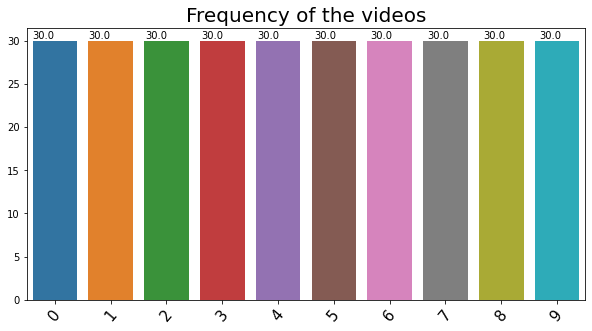

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,5))
ax = sns.barplot(y=df['labels'].value_counts().values,x=df['labels'].value_counts().index)
for i in ax.patches:
  ax.annotate(str(i.get_height()),(i.get_x()*1.01,i.get_height()*1.01))
plt.xticks(rotation=50,fontsize=15)
plt.title('Frequency of the videos',fontsize=20)
plt.show()

### Classification of the labels

In [ ]:
# Categorical classification of the videos
for i in zip(range(0,len(raw.target_names)),raw.target_names):
    print(i)

(0, '0')
(1, '1')
(2, '2')
(3, '3')
(4, '4')
(5, '5')
(6, '6')
(7, '7')
(8, '8')
(9, '9')


In [ ]:
# Checking the target
target # Here the numbers means the labels of the categories

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
# Splitting the train data for making the validation set
valid_files = train_files[200:]
valid_targets = train_targets[200:]
train_files = train_files[:200]
train_targets =  train_targets[:200]

print('Train files size : ',train_files.shape[0])
print('Train targets size : ',train_targets.shape[0])

print('Validation file(s) size : ',valid_files.shape[0])
print('Validation tragets size : ',valid_targets.shape[0])

print('Test file(s) size : ',test_files.shape[0])
print('Test tragets size : ',test_targets.shape[0])

Train files size :  200
Train targets size :  200
Validation file(s) size :  40
Validation tragets size :  40
Test file(s) size :  60
Test tragets size :  60


In [ ]:
pip install sk-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from zmq.constants import CHANNEL
import numpy as np
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm


class Videos(object):

    def __init__(self, target_size=None, to_gray=True, max_frames=None,
                 extract_frames='middle', required_fps=None,
                 normalize_pixels=None):
        """
        Initializing the config variables
        Parameters:
            target_size (tuple): (New_Width, New_Height), Default 'None'
                A tuple denoting the target width and height of each frame in each of the video
            to_gray (boolean): Default 'True'
                If True, then each frame will be converted to gray scale. Otherwise, not.
            max_frames (int): Default 'None'
                The maximum number of frames to return for each video.
                Extra frames are removed based on the value of 'extract_frames'.
            extract_frames (str): {'first', 'middle', 'last'}, Default 'middle'
                'first': Extract the first 'N' frames
                'last': Extract the last 'N' frames
                'middle': Extract 'N' frames from the middle
                    Remove ((total_frames - max_frames) // 2) frames from the beginning as well as the end
            required_fps (int): Default 'None'
                Capture 'N' frame(s) per second from the video.
                Only the first 'N' frame(s) for each second in the video are captured.
            normalize_pixels (tuple/str): Default 'None'
                If 'None', the pixels will not be normalized.
                If a tuple - (New_min, New_max) is passed, Min-max Normalization will be used.
                If the value is 'z-score', then Z-score Normalization will be used.
                For each pixel p, z_score = (p - mean) / std
        """

        self.target_size = target_size
        self.to_gray = to_gray
        self.max_frames = max_frames
        self.extract_frames = extract_frames
        self.required_fps = required_fps
        self.normalize_pixels = normalize_pixels
        self.fps = None

    def read_videos(self, paths):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        list_of_videos = [
            self._read_video(path) for path in tqdm(paths)
        ]

        tensor = np.vstack(list_of_videos)

        if self.normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(self.normalize_pixels) == tuple) and (len(self.normalize_pixels) == 2):
                base = self.normalize_pixels[0]
                r = self.normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif self.normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

    def get_frame_count(self, paths):
        """
        Can be used to determine the value of `max_frames`
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

    def _read_video(self, path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        self.fps = int(cap.inputfps)                  # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):

            capture_frame = True
            if self.required_fps != None:
                is_valid = range(self.required_fps)
                capture_frame = (index % self.fps) in is_valid

            if capture_frame:
                if self.target_size is not None:
                    temp_image = array_to_img(frame)
                    frame =img_to_array(
                        temp_image.resize(
                            self.target_size,
                            Image.ANTIALIAS)).astype('uint8')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if self.to_gray:
            temp_video = rgb2gray(temp_video)
                
        if self.max_frames is not None:
            temp_video = self._process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

    def _process_video(self, video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)
                Video whose frames are to be extracted
        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if self.max_frames <= total_frames:

            if self.extract_frames == 'first':
                video = video[:self.max_frames]
            elif self.extract_frames == 'last':
                video = video[(total_frames - self.max_frames):]
            elif self.extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - self.max_frames) // 2) + 1    
                video = video[front:(front + self.max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video

100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

Sample : 

Number of videos : 1
Frames for each video :  20
Dimensions of the frame  height x width:  (144, 176)
Colors in the image : 3


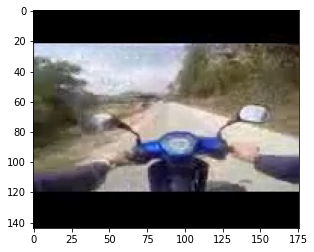

In [ ]:
# Making the sample and checking the video 
sample_files = train_files[:1]

reader = Videos(target_size=None,to_gray=False,max_frames=20)

sample = reader.read_videos(sample_files)

print("Sample : \n")
print('Number of videos :',sample.shape[0])
print('Frames for each video : ',sample.shape[1])
print('Dimensions of the frame  height x width: ',(sample.shape[2],sample.shape[3]))
print('Colors in the image :',sample.shape[-1])

plt.imshow(sample[0][3])
plt.show()

## Data Preprocessing

### Traininng Dataset


In [ ]:
# Training
reader = Videos(target_size=(224,224), 
                to_gray=False, 
                max_frames=14, 
                extract_frames='middle', 
                required_fps=5, 
                normalize_pixels=(-1, 1))       


# Converting the training data videos into tensors
x_train = reader.read_videos(train_files)

print('Created tensors for the training successfully!!')

100%|██████████| 200/200 [01:14<00:00,  2.69it/s]


Created tensors for the training successfully!!


In [ ]:
print("Training Set : \n")
print('Number of videos :',x_train.shape[0])
print('Frames for each video : ',x_train.shape[1])
print('Dimensions of the frame  height x width: ',(x_train.shape[2],x_train.shape[3]))
print('Colors in the image :',x_train.shape[-1])

Training Set : 

Number of videos : 200
Frames for each video :  14
Dimensions of the frame  height x width:  (224, 224)
Colors in the image : 3


In [ ]:
from keras.utils import to_categorical

# Removing the videos which gave the errors on the frame conversion

y_train = to_categorical(train_targets)

In [ ]:
print(y_train[:3],train_targets[:3])

print('Shape of the Y-train :',y_train.shape)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [7 1 0]
Shape of the Y-train : (200, 10)


### Validation set

In [ ]:
x_valid = reader.read_videos(valid_files)
print()
print('Created tensors for the validation successfully!!')

100%|██████████| 40/40 [00:13<00:00,  2.96it/s]



Created tensors for the validation successfully!!


In [ ]:
print("Validation Set : \n")
print('Number of videos :',x_valid.shape[0])
print('Frames for each video :',x_valid.shape[1])
print('Dimensions of the frame  height x width:',(x_valid.shape[2],x_valid.shape[3]))
print('Colors in the image :',x_valid.shape[-1])

Validation Set : 

Number of videos : 40
Frames for each video : 14
Dimensions of the frame  height x width: (224, 224)
Colors in the image : 3


In [ ]:
valid_files,valid_targets

(array(['/content/drive/MyDrive/videos/3/-2f7n5RNe-Q.mp4',
        '/content/drive/MyDrive/videos/1/0OVjM9WYX7U.mp4',
        '/content/drive/MyDrive/videos/8/-3xIiWHYntU.mp4',
        '/content/drive/MyDrive/videos/0/03LexUfuweY.mp4',
        '/content/drive/MyDrive/videos/2/0UikhkRfKJU.mp4',
        '/content/drive/MyDrive/videos/5/-cVVZilz84E.mp4',
        '/content/drive/MyDrive/videos/9/0gk7bMlB2EY.mp4',
        '/content/drive/MyDrive/videos/4/09_k1eXA-U8.mp4',
        '/content/drive/MyDrive/videos/9/0Nhl-MOqbAg.mp4',
        '/content/drive/MyDrive/videos/8/-6wJNL8d5jA.mp4',
        '/content/drive/MyDrive/videos/1/0WaOzOgL1l4.mp4',
        '/content/drive/MyDrive/videos/1/0GrHY5kiJuU.mp4',
        '/content/drive/MyDrive/videos/5/07eq1ZyNg_U.mp4',
        '/content/drive/MyDrive/videos/6/-iDkg_goNbs.mp4',
        '/content/drive/MyDrive/videos/9/0nL-oCzLfpw.mp4',
        '/content/drive/MyDrive/videos/6/-hO6M87D6iA.mp4',
        '/content/drive/MyDrive/videos/5/-xsG5SRE6YM.mp4

In [ ]:
y_valid = to_categorical(valid_targets)

y_valid,valid_targets

(array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],


In [ ]:
y_valid.shape

(40, 10)

# model

In [ ]:
x_train.shape

(200, 14, 224, 224, 3)

In [ ]:

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten,GRU,Input
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,TimeDistributed,MaxPool2D,AveragePooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50,VGG16
from keras.models import Model

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(10, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = tf.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(x_train, y_train, batch_size=32),
	steps_per_epoch=len(x_train) // 32,
	validation_data=valAug.flow(x_valid, y_valid),
	validation_steps=len(x_valid) // 32,
	epochs=20)

[INFO] compiling model...
[INFO] training head...


ValueError: ignored

In [ ]:
model = Sequential()
# input, with 64 convolutions for 5 images
# that have (224, 224, 3) shape
model.add(
    TimeDistributed(
        Conv2D(64, (3,3), 
            padding='same', strides=(2,2), activation='relu')
        ,input_shape = (14, 128, 128, 3)
    )
)
model.add(Dropout(0.5))

model.add(
    TimeDistributed( 
        Conv2D(64, (3,3), 
            padding='same', strides=(2,2), activation='relu')
    )
)
model.add(Dropout(0.5))

model.add(
    TimeDistributed(
        MaxPooling2D((2,2), strides=(2,2))
    )
)
# Second conv, 128
model.add(
    TimeDistributed(
        Conv2D(128, (3,3),
            padding='same', strides=(2,2), activation='relu')
    )
)
model.add(Dropout(0.5))

model.add(
    TimeDistributed( 
        Conv2D(128, (3,3),
            padding='same', strides=(2,2), activation='relu')
    )
)
model.add(
    TimeDistributed(
        MaxPooling2D((2,2), strides=(2,2))
    )
)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:

#input and output
x_train_Den = np.random.normal(size=(14,128,128,3))
x_val = np.random.normal(size=(14,128,128,3))
aug_y_train = tf.random.uniform((14, ), maxval=3, dtype=tf.int32)
aug_y_valid = tf.random.uniform((14, ), maxval=3, dtype=tf.int32)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(x_train_Den)
datagen.fit(x_val)

In [ ]:
model.compile('adam', loss= 'categorical_crossentropy',metrics='accuracy')

In [ ]:

batch_size= 16
epochs=25
history = model.fit(datagen.flow(x_train_Den, aug_y_train, batch_size=batch_size),
                     epochs=epochs,validation_data=(x_val,aug_y_valid))

Epoch 1/25


ValueError: ignored

In [ ]:
model.fit(x_train,y_train,epochs=50,validation_data=(x_valid,y_valid))  

Epoch 1/50
7/7 [==============================] - 2s 239ms/step - loss: 0.0288 - accuracy: 0.9900 - val_loss: 9.0589 - val_accuracy: 0.1750
Epoch 2/50
7/7 [==============================] - 1s 193ms/step - loss: 0.0285 - accuracy: 0.9850 - val_loss: 7.3056 - val_accuracy: 0.3000
Epoch 3/50
7/7 [==============================] - 1s 191ms/step - loss: 0.0487 - accuracy: 0.9700 - val_loss: 7.4629 - val_accuracy: 0.2500
Epoch 4/50
7/7 [==============================] - 1s 193ms/step - loss: 0.0979 - accuracy: 0.9750 - val_loss: 6.7859 - val_accuracy: 0.3000
Epoch 5/50
7/7 [==============================] - 1s 193ms/step - loss: 0.0395 - accuracy: 0.9800 - val_loss: 7.7451 - val_accuracy: 0.3000
Epoch 6/50
7/7 [==============================] - 1s 192ms/step - loss: 0.0323 - accuracy: 0.9950 - val_loss: 8.1597 - val_accuracy: 0.3250
Epoch 7/50
7/7 [==============================] - 1s 193ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 8.6247 - val_accuracy: 0.2750
Epoch 8/50
7/7 [====

In [ ]:
model = Sequential()

model.add(TimeDistributed(
        Conv2D(64, (3,3), 
            padding='same', strides=(2,2), activation='relu')
        ,input_shape = (15, 128, 128, 1)
    ))

model.add(TimeDistributed(Conv2D(64,kernel_size=(3,3),padding="same", activation="relu")))
model.add(Dropout(0.5))

model.add(TimeDistributed(MaxPool2D(pool_size=(2,2),strides=(2,2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(MaxPool2D(pool_size=(2,2),strides=(2,2))))

model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu")))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(MaxPool2D(pool_size=(2,2),strides=(2,2))))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(MaxPool2D(pool_size=(2,2),strides=(2,2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu")))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu")))
model.add(Dropout(0.5))

model.add(TimeDistributed(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16')))

model.add(Flatten(name='flatten'))

model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', name='fc2'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

### Test data 

In [ ]:
x_test = reader.read_videos(np.delete(test_files,[1]))
print()
print('Created tensors for the testing successfully!!')

100%|██████████| 19/19 [00:05<00:00,  3.63it/s]



Created tensors for the testing successfully!!


In [ ]:
print("Test Set : \n")
print('Number of videos :',x_test.shape[0])
print('Frames for each video :',x_test.shape[1])
print('Dimensions of the frame  height x width:',(x_test.shape[2],x_test.shape[3]))
print('Colors in the image :',x_test.shape[-1])

Test Set : 

Number of videos : 19
Frames for each video : 15
Dimensions of the frame  height x width: (128, 128)
Colors in the image : 3


In [ ]:
y_test = to_categorical(np.delete(test_targets,[1]),num_classes=10)

print(y_test,np.delete(test_targets,[1]))

print('Shape of the y_test :',y_test.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]] [8 7 4 4 3 2 8 1 0 1 3 7 3 9 0 7 7 1 3]
Shape of the y_test : (19, 10)


In [ ]:
x_train.shape

TensorShape([15, 128, 128, 3])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling3D, Conv3D, Flatten, Dropout,BatchNormalization

model = Sequential()
model.add(Conv3D(
            16, (3,3,3), activation='relu', input_shape=(15, 128, 128, 3)
        ))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv3D(
            16, (3,3,3), activation='relu'
        ))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model.add(Conv3D(
            16, (3,3,3), activation='relu'
        ))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )


history = model.fit(x_train,y_train,epochs=50,validation_data=(x_valid,y_valid))  

Epoch 1/50
2/2 [==============================] - 6s 2s/step - loss: 6.9294 - accuracy: 0.1500 - val_loss: 3.1603 - val_accuracy: 0.1000
Epoch 2/50
2/2 [==============================] - 1s 363ms/step - loss: 2.5789 - accuracy: 0.5333 - val_loss: 4.1053 - val_accuracy: 0.0500
Epoch 3/50
2/2 [==============================] - 1s 363ms/step - loss: 2.1074 - accuracy: 0.6833 - val_loss: 3.3275 - val_accuracy: 0.0500
Epoch 4/50
2/2 [==============================] - 1s 368ms/step - loss: 0.8500 - accuracy: 0.8000 - val_loss: 2.7988 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 1s 365ms/step - loss: 0.3391 - accuracy: 0.8667 - val_loss: 2.8581 - val_accuracy: 0.1000
Epoch 6/50
2/2 [==============================] - 1s 372ms/step - loss: 0.4136 - accuracy: 0.9500 - val_loss: 3.1216 - val_accuracy: 0.1000
Epoch 7/50
2/2 [==============================] - 1s 365ms/step - loss: 0.1846 - accuracy: 0.9333 - val_loss: 3.6436 - val_accuracy: 0.1000
Epoch 8/50
2/2 [===

# try 1

In [ ]:
x_valid.shape

In [ ]:
y_train.shape

In [ ]:
y_valid.shape

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(axis=-1),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.BatchNormalization(axis=-1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(axis=-1),

    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization() ,
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(10,activation='softmax')

])

learning_rate = 0.001
epochs=20
opt= tf.keras.optimizers.Adam(learning_rate=learning_rate , decay=learning_rate/(epochs*0.5))
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


aug = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=10,
          zoom_range=0.15,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.15,
          horizontal_flip= False,
          vertical_flip= False,
          fill_mode="nearest"
          )
          

x_train = tf.random.normal((14, 128, 128, 3))
y_train = tf.random.uniform((14, ), maxval=3, dtype=tf.int32)

x_valid = tf.random.normal((14, 128, 128, 3))
y_valid = tf.random.uniform((14, ), maxval=3, dtype=tf.int32)
history = model.fit(aug.flow(x_train, y_train, batch_size=2), epochs=100,validation_data=(x_valid,y_valid))

Epoch 1/100
7/7 [==============================] - 2s 50ms/step - loss: 3.5165 - accuracy: 0.0714 - val_loss: 2.4356 - val_accuracy: 0.2143
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 5.0726 - accuracy: 0.2143 - val_loss: 2.5130 - val_accuracy: 0.2143
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 3.7912 - accuracy: 0.2857 - val_loss: 2.4996 - val_accuracy: 0.2143
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 3.6544 - accuracy: 0.3571 - val_loss: 2.4890 - val_accuracy: 0.2143
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 3.1351 - accuracy: 0.2143 - val_loss: 2.3103 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 3.6888 - accuracy: 0.4286 - val_loss: 2.2261 - val_accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 17ms/step - loss: 6.0870 - accuracy: 0.0714 - val_loss: 1.9943 - val_accuracy: 0.5000
Epoch 8/100
7/7 

In [ ]:
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")

aug = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=10,
          zoom_range=0.15,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.15,
          horizontal_flip= False,
          vertical_flip= False,
          fill_mode="nearest"
          )
valAug = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=10,
          zoom_range=0.15,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.15,
          horizontal_flip= False,
          vertical_flip= False,
          fill_mode="nearest"
          )         

x_train = tf.random.normal((15, 128, 128, 1))
y_train = tf.random.uniform((15, ), maxval=3, dtype=tf.int32)

x_valid = tf.random.normal((15, 128, 128, 1))
y_valid = tf.random.uniform((15, ), maxval=3, dtype=tf.int32)
model.fit(
	x=aug.flow(x_train, y_train,batch_size=32),
	steps_per_epoch=len(x_train) // 32,
	validation_data=valAug.flow(x_valid, y_valid),
	validation_steps=len(x_valid) // 32,
	epochs=20)


In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [ ]:
HEIGHT=128
WIDTH=128

In [ ]:
input_shape = (200, 14, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [ ]:

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.imagenet_utils import preprocess_input

# train_gen = ImageDataGenerator(
#             preprocessing_function=preprocess_input,
#             rotation_range=40, 
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             shear_range=0.2,
#             zoom_range=0.2,
#             horizontal_flip=True,
#             fill_mode='nearest')

# # fit training generator
  
# val_gen= ImageDataGenerator(
#             preprocessing_function=preprocess_input,
#             rotation_range=40, 
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             shear_range=0.2,
#             zoom_range=0.2,
#             horizontal_flip=True,
#             fill_mode='nearest')

# # fit validation generator

# aug_x_train = tf.random.normal((14, 128, 128, 3))
# aug_y_train = tf.random.uniform((14, ), maxval=3, dtype=tf.int32)

# aug_x_valid = tf.random.normal((14, 128, 128, 3))
# aug_y_valid = tf.random.uniform((14, ), maxval=3, dtype=tf.int32)
# val_gen.fit(aug_x_valid)
# train_gen.fit(aug_x_train)


In [ ]:
# frames, label = next(iter(train_gen))
model.build(x_train)

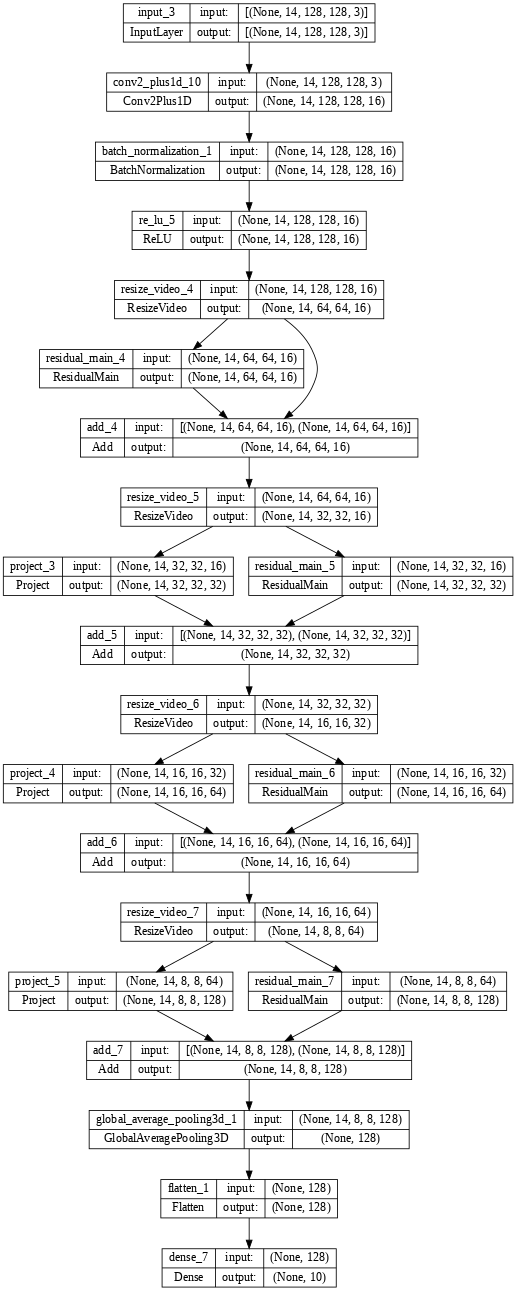

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [ ]:
model.fit(
	x=trainAug.flow(x_train, y_train, batch_size=32),
	steps_per_epoch=len(x_train) // 32,
	validation_data=valAug.flow(x_valid, y_valid),
	validation_steps=len(x_valid) // 32,
	epochs=30)

ValueError: ignored